# TTS to 2.7KHz SSB signal

In [1]:
!pip install gTTS pydub soundfile

### Test TTS to MP3

In [2]:
# Import the required module for text 
# to speech conversion
from gtts import gTTS
  
# This module is imported so that we can 
# play the converted audio
import os
  
# The text that you want to convert to audio
mytext = 'CQ test CQ test CQ test from india uniform two foxtrot radio lima, italy uniform two foxtrot radio lima calling and standing by'
  
# Language in which you want to convert
language = 'en'
  
# Passing the text and language to the engine, 
# here we have marked slow=False. Which tells 
# the module that the converted audio should 
# have a high speed
myobj = gTTS(text=mytext, lang=language, slow=False)
  
# Saving the converted audio in a mp3 file named
# welcome 
myobj.save("cq-test.mp3")

### FFT function

In [3]:
import matplotlib.pyplot as plt
def draw_fft(input_data, sampling_rate, min, max, title = "FFT of given signal"):
    num_samples = len(input_data)
    duration = num_samples/sampling_rate
    fft_result = np.fft.fft(input_data)
    freq_axis = np.fft.fftfreq(num_samples, d=1/sampling_rate)
    
    # Plot the magnitude spectrum
    plt.figure(figsize=(10, 6))
    plt.plot(freq_axis, np.abs(fft_result))
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.xlim(min, max)
    plt.grid()
    plt.show()

### MP3 read function

In [6]:
import numpy as np
import pydub
def read(f, normalized=False):
    a = pydub.AudioSegment.from_mp3(f)
    y = np.array(a.get_array_of_samples())
    if a.channels == 2:
        y = y.reshape((-1, 2))
    if normalized:
        return a.frame_rate, np.float32(y) / 2**15
    else:
        return a.frame_rate, y

### Plot FFT

Sampling rate: 24000
Samples: 309312


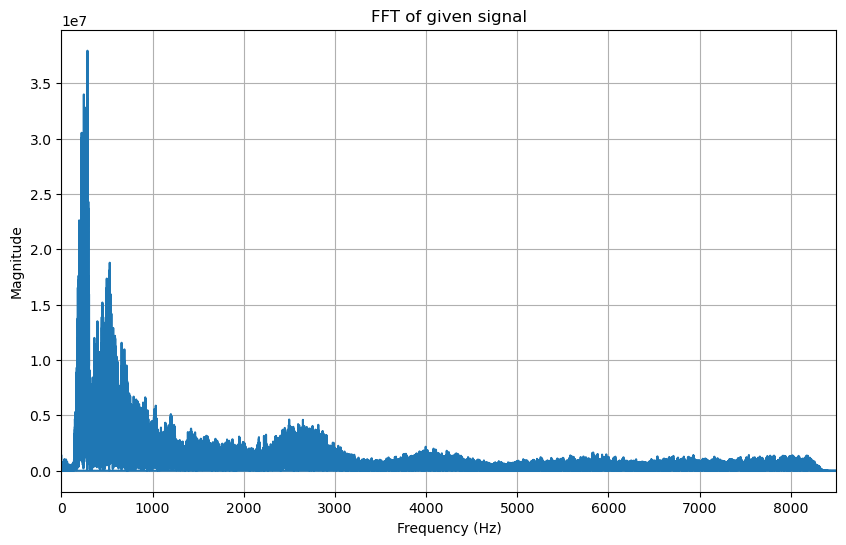

In [7]:
tmp = read('cq-test.mp3')
sampling_rate = tmp[0]
audio = tmp[1]
print("Sampling rate: " + str(sampling_rate))
print("Samples: " + str(len(audio)))
# Perform FFT
draw_fft(audio, sampling_rate, 0, 8500)

### Audio output

In [8]:
from IPython.display import Audio
# Play the audio
Audio(data=audio, rate=sampling_rate)

### Apply SSB filter

In [9]:
# https://americodias.com/docs/python/audio_python.md
def fir_band_pass(samples, fs, fL, fH, NL, NH, outputType):
    # Referece: https://fiiir.com

    fH = fH / fs
    fL = fL / fs

    # Compute a low-pass filter with cutoff frequency fH.
    hlpf = np.sinc(2 * fH * (np.arange(NH) - (NH - 1) / 2.))
    hlpf *= np.blackman(NH)
    hlpf /= np.sum(hlpf)
    # Compute a high-pass filter with cutoff frequency fL.
    hhpf = np.sinc(2 * fL * (np.arange(NL) - (NL - 1) / 2.))
    hhpf *= np.blackman(NL)
    hhpf /= np.sum(hhpf)
    hhpf = -hhpf
    hhpf[int((NL - 1) / 2)] += 1
    # Convolve both filters.
    h = np.convolve(hlpf, hhpf)
    # Applying the filter to a signal s can be as simple as writing
    s = np.convolve(samples, h).astype(outputType)

    return s

# Using custom SSB filter
samples_filtered = fir_band_pass(audio, sampling_rate, 300, 2700, 461, 461, np.int16)

### Plot filtered audio

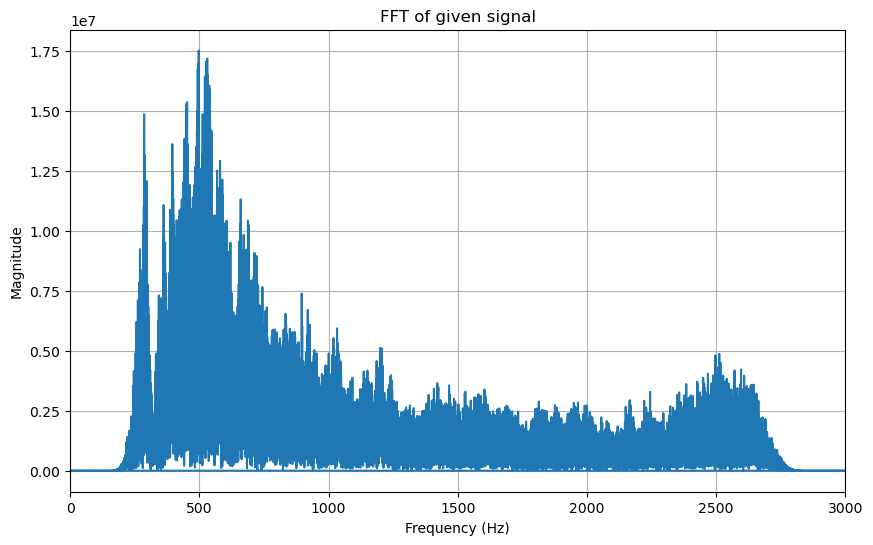

In [20]:
draw_fft(samples_filtered, sampling_rate, 0, 3000)

### Audio output

In [10]:
from IPython.display import Audio
# Play the audio
Audio(data=samples_filtered, rate=sampling_rate)

### Export to MP3

In [13]:
import soundfile
soundfile.write("cq-test-filtered.mp3", samples_filtered, 24000)

# SSB manipulation

In [14]:
!pip install audiomentations==0.23.0

  Using cached audiomentations-0.23.0-py3-none-any.whl (65 kB)
  Using cached librosa-0.9.2-py3-none-any.whl (214 kB)
  Using cached audioread-3.0.0-py3-none-any.whl
  Using cached resampy-0.4.2-py3-none-any.whl (3.1 MB)


### Adding noise to SSB

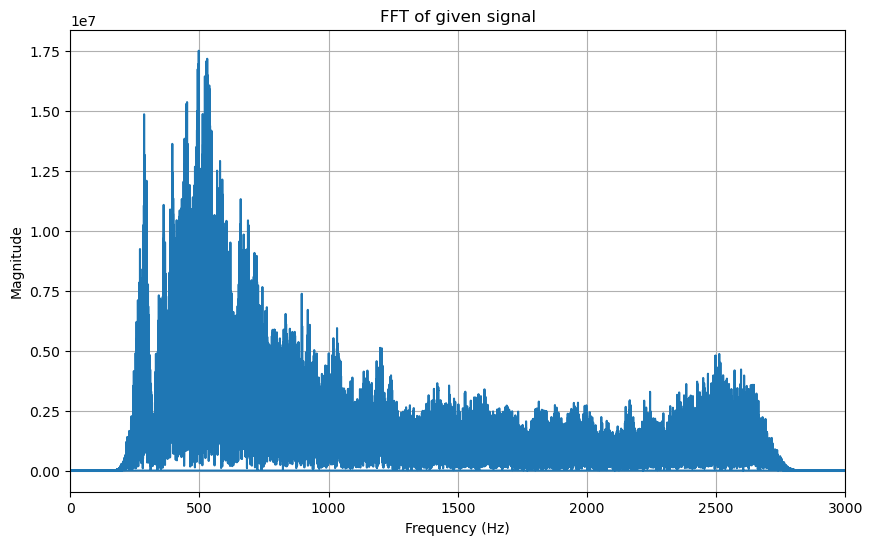

In [18]:
from audiomentations import Compose, AddGaussianNoise, AddGaussianSNR, AddBackgroundNoise
augment = Compose([
    AddGaussianNoise(min_amplitude=10, max_amplitude=15, p=0.5),
    AddGaussianSNR(min_snr_in_db=20.0, max_snr_in_db=100.0, p=1.0)
    #AddBackgroundNoise()
    #TimeStretch(min_rate=0.8, max_rate=1.25, p=0.5),
    #PitchShift(min_semitones=-4, max_semitones=4, p=0.5),
    #Shift(min_fraction=-0.5, max_fraction=0.5, p=0.5),
])
augmented_samples = augment(samples=samples_filtered, sample_rate=sampling_rate)
draw_fft(augmented_samples, sampling_rate, 0, 3000)

In [19]:
from IPython.display import Audio
# Play the audio
Audio(data=augmented_samples, rate=sampling_rate)

## Add background noise

In [ ]:
!pip install pydub

In [ ]:
from pydub import AudioSegment
sound1 = AudioSegment.from_file("cq-test-filtered.mp3", format="mp3")
sound2 = AudioSegment.from_file("hf-noise-usb.mp3", format="mp3")

# sound1 6 dB louder
louder = sound1 + 6

# sound1, with sound2 appended (use louder instead of sound1 to append the louder version)
combined = sound1.overlay(sound2, position=0)

# simple export
file_handle = combined.export("cq-test-noise.mp3", format="mp3")

### Audio output

In [ ]:
from IPython.display import Audio
# Play the audio
Audio(filename="cq-test-noise.mp3", rate=sampling_rate)